# Novelty detection using 1-class SVM

Classifies new data as similar or different to the training set.  This method is an unsupervised method that builds a decision boundary between the data and origin in kernel space and can be used as a novelty detector.

In [37]:
# Setup
%load_ext sql
# %sql postgresql://gpdbchina@10.194.10.68:55000/madlib
%sql postgresql://fmcquillan@localhost:5432/madlib
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


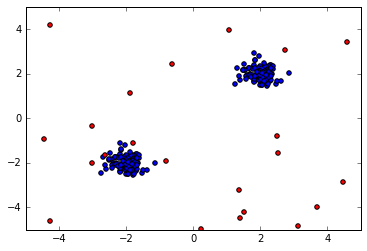

In [38]:
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
X_train_D = pd.DataFrame(X_train, columns=['x1', 'x2'])

# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-7, high=7, size=(40, 2))
X_outliers_D = pd.DataFrame(X_outliers, columns=['x1', 'x2'])

b = plt.scatter(X_train[:, 0], X_train[:, 1], c='blue')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()

In [39]:
# Build tables
%sql DROP TABLE IF EXISTS X_train_D CASCADE
%sql PERSIST X_train_D
%sql ALTER TABLE X_train_D add column X float[]
%sql update X_train_D set X = array[x1, x2]::float[]

%sql DROP TABLE IF EXISTS X_outliers_D CASCADE
%sql PERSIST X_outliers_D
%sql ALTER TABLE X_outliers_D add column X float[]
%sql update X_outliers_D set X = array[x1, x2]::float[]

Done.
Done.
200 rows affected.
Done.
Done.
40 rows affected.


[]

In [40]:
%%sql 
-- Train the model
DROP TABLE IF EXISTS svm_out1, svm_out1_summary, svm_out1_random CASCADE;
SELECT madlib.svm_one_class(
    'X_train_D',    -- source table
    'svm_out1',     -- output table
    'X',            -- features
    'gaussian',     -- kernel
    'gamma=1, n_components=55, random_state=3', 
    NULL,           -- grouping 
    'init_stepsize=0.1, lambda=10, max_iter=100, tolerance=0'  
    );
SELECT * FROM svm_out1; 

Done.
1 rows affected.
1 rows affected.


coef,loss,norm_of_gradient,num_iterations,num_rows_processed,num_rows_skipped,dep_var_mapping
"[-0.0652579039751, -0.132031595902, -0.736674560761, 0.110776065553, -0.257405638109, 0.0592959032279, 0.394264859682, -0.696044045897, 0.355378680096, -0.917519476201, 0.499471522957, -0.050984665751, -0.134700659181, -0.0705623616132, -0.0440350483425, -0.730837500515, -0.0321151797135, -0.893641152253, -0.686424263168, -0.568143960852, -0.12323421025, -0.136522678866, -0.626743403999, -0.256609467659, -0.285826104108, -0.117860781456, 0.318213569126, 0.465683621798, 0.569073368875, -0.319718151386, -0.032926380078, 0.330495474386, 0.0426841287321, 0.621705430279, 0.444381604771, 0.347966836495, 0.0573812330683, -0.103244905478, -0.575045339435, -0.101783824252, 0.624406852044, 0.113168204922, 0.506933705459, 0.560256594355, 0.142564738705, 0.338469597153, -0.0531770790698, 0.107924238733, 0.665718502542, 0.712455036796, -0.265273701697, -0.133616355952, 0.413526223018, -0.277088845804, -0.49433371065, -1.00004534127]",73.1866371844,113.184300907,100,201,-1,"[-1.0, 1.0]"


In [41]:
# Prediction
# First for the training data
%sql drop table if exists y_pred_train;
%sql SELECT madlib.svm_predict('svm_out1', 'X_train_D', 'index', 'y_pred_train');
y_pred_train = %sql SELECT * from y_pred_train; 

# Next for the outliers
%sql drop table if exists y_pred_outliers;
%sql SELECT madlib.svm_predict('svm_out1', 'X_outliers_D', 'index', 'y_pred_outliers');
y_pred_outliers = %sql SELECT * from y_pred_outliers; 

%sql SELECT * FROM y_pred_outliers limit 20; -- Show the outliers
#%sql SELECT * FROM y_pred_train limit 20; -- Show the training data

Done.
1 rows affected.
200 rows affected.
Done.
1 rows affected.
40 rows affected.
20 rows affected.


index,prediction,decision_function
0,-1.0,-0.185553475523
1,-1.0,-0.998404919902
2,-1.0,-0.338487093573
3,-1.0,-0.307355005857
4,-1.0,-1.07966449719
5,-1.0,-1.97175772304
6,-1.0,-2.20381705572
7,-1.0,-2.06660552658
8,-1.0,-1.44928341418
9,-1.0,-0.418765699618


In [42]:
# Predict over the decision grid for plotting
# xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['x1', 'x2'])

%sql DROP TABLE IF EXISTS grid_points CASCADE
%sql PERSIST grid_points
%sql ALTER TABLE grid_points add column X float[]
%sql update grid_points set X = array[x1, x2]::float[]

Done.
Done.
10000 rows affected.


[]

Done.
1 rows affected.
10000 rows affected.


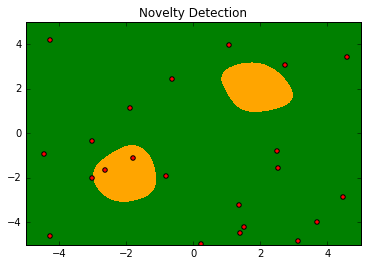

In [45]:
# Plot the decision grid
%sql drop table if exists Z_D;
%sql SELECT madlib.svm_predict('svm_out1', 'grid_points', 'index', 'Z_D');
Z_D = %sql SELECT decision_function from Z_D order by index
Z = np.array(Z_D)
Z = Z.reshape(xx.shape)

# Orange is not novel, green is novel
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')
plt.contourf(xx, yy, Z, levels=[Z.min(), 0], colors='green')
#plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 7), cmap=plt.cm.Blues_r)
#b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='blue')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.show()